## Dynamic Flux Based Analysis

Calculating a single number for the progesterone yield and flux - as we mostly do during this report - gives little information about what the final titres will be. 
To get a better idea of how the progesterone and biomass titres change over time, it can be insightful to mimick real conditions by simulating a simple batch fermentation. This is the purpose of Dynamic Flux Based Analysis (DFBA).

We used cobra and dfba packages to make a DFBA and simulate a batch fermentation to estimate the final titre of progesterone in defined intitial conditions. The titre of the precursor squalene is estimated as well in order to compare our simulation with experimental results from literature.

The code is run in the following steps:
 - Load libraries and model
 - Calculcate optimal fluxes for biomass and progesterone and adjust the lowerbound for progesterone.
 - Make DFBA model
 - Add Kinetic variables 
 - Add Exchange Fluxes
 - Add right-hand-side expressions (rhs) for kinetic variables
 - Lower/upper bound expressions for exchange fluxes
 - Define initial conditions
 - Run simulation and plot concentrations and trajectories.
 - Investigate relationship between initial glucose concentration and final progesterone titre

It is important to note, that this code requires another version of python than our other scripts are running. It might therefore be necessary to make a new environment with python version 3.7 and install the dfba package in order to run this script. In ubuntu, you can use the quoted code below. Otherwise, see the details in requirements_dfba.txt.

In [1]:
#Create an environment to install dfba and run this script.

# conda create --name dfba python=3.7
# conda activate dfba
# conda install -c conda-forge dfba

In [2]:
# Load libraries
from cobra.io import read_sbml_model
from dfba.plot.matplotlib import *
from dfba import DfbaModel, ExchangeFlux, KineticVariable

In [3]:
# Loading model
infilename = 'models/iMM904_progesterone_coswap1.xml'
print(f"Loading {infilename}")
model = read_sbml_model(infilename)

Loading models/iMM904_progesterone_coswap1.xml


To ensure that our strain can grow while producing progesterone, we find the optimal progesterone productivity and growth rate (see 03_maximum theoretical yield). To simulate the optimal model in steady state, we define a progesterone productivity from the obtained results:

In [4]:
# max growth rate and max progesterone productivity
with model:
    baseline_max_growth = model.optimize().objective_value
    model.objective = model.reactions.DM_progesterone_c
    baseline_max_production = model.optimize().objective_value
print(f"Maximum growth rate: {baseline_max_growth} gDW/h")
print(f"Maximum progesterone production: {baseline_max_production} mmol/gDW*h")

Maximum growth rate: 0.293733937604556 gDW/h
Maximum progesterone production: 0.1666666666666663 mmol/gDW*h


In [5]:
# growth and progesterone productivity when both are set to be objective
with model:
    model.objective = {model.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
                    model.reactions.get_by_id('DM_progesterone_c'): baseline_max_growth} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = model.optimize()
    growth = solution.fluxes['BIOMASS_SC5_notrace']
    progesterone = solution.fluxes['DM_progesterone_c'] #*1000 /314.46
    o_uptake = solution.fluxes['EX_o2_e']
    glc_uptake = solution.fluxes['EX_glc__D_e']
    print(f"Growth rate in complete model: {growth} gDW/h")
    print(f"Progesterone productivity in complete model: {progesterone} mmol/gDW*h")
    print(f"Growth rate in complete model: {growth} gDW/h")
    print(f"Progesterone productivity in complete model: {progesterone} mmol/gDW*h")

Growth rate in complete model: 0.1770861354253897 gDW/h
Progesterone productivity in complete model: 0.15467338469999697 mmol/gDW*h
Growth rate in complete model: 0.1770861354253897 gDW/h
Progesterone productivity in complete model: 0.15467338469999697 mmol/gDW*h


Now we have calculated the optimal fluxes for progesterone and biomass when they are both set to the objective for the model. Unfortunately, this DFBA simulation does not work when two reactions are set as the objective. 
Therefore, we chose to keep biomass as the objective and then force the progesterone flux to the value ~0.156 mmol/(gDW*h), as calculated above. 

In [6]:
# Setting progesterone productivity constant
#progesterone_gh = progesterone * 1000 / 314.46 # calculate progesterone productivity in g/gDW*h
#print(f"Setting progesterone productivity to: {progesterone_gh} g/gDW*h")

model.reactions.DM_progesterone_c.lower_bound = progesterone
print(f"Setting progesterone productivity to: {progesterone} g/gDW*h")


Setting progesterone productivity to: 0.15467338469999697 g/gDW*h


Now we have defined the model as it should be for batch simulation. Then we can start defining the kinetic variables, exchange fluxes, and equations that we are using in the simulation. 

In [7]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

In [8]:
# instances of KineticVariable
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Sqr = KineticVariable("Squalene")
Pro = KineticVariable("Progesterone")

# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([X, Gluc, Sqr, Pro])

In [9]:
# instances of ExchangeFlux
mu = ExchangeFlux("BIOMASS_SC5_notrace")
v_G = ExchangeFlux("EX_glc__D_e")
v_O = ExchangeFlux("EX_o2_e")
v_S = ExchangeFlux("SQLS")
v_P = ExchangeFlux("DM_progesterone_c")

# add exchange fluxes to dfba_model
dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_S, v_P]) #v_O

In [10]:
# add rhs expressions for kinetic variables in dfba_model
Vgmax = 8.5
Kg = 0.5
#Gin = 100.0
Vomax = 8.0

#This is flux terms:
#dfba_model.add_rhs_expression("Volume", D)
#dfba_model.add_rhs_expression("Oxygen", 0) #keep O2 constant
dfba_model.add_rhs_expression("Biomass", mu * X )
dfba_model.add_rhs_expression("Glucose", v_G * X )#* 180.1559 / 1000 ) #+ D * (Gin - Gluc) / V
dfba_model.add_rhs_expression("Squalene", v_S * X )# ) # - D * Pro / V
dfba_model.add_rhs_expression("Progesterone", v_P * X )# ) # - D * Pro / V


In [11]:
# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

Oxy = 2
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

In [12]:
# add initial conditions for kinetic variables in dfba_model biomass (gDW/L),
# metabolites in mmol/L

dfba_model.add_initial_conditions(
    {
        "Biomass": 0.05,
        "Glucose": 10,
        "Squalene": 0.0,
        "Progesterone": 0.0
    }
)

In [13]:
# simulate model across interval t = [0.0,16.0](hours) with outputs for plotting
# every 0.1h
concentrations, trajectories = dfba_model.simulate(0.0, 100, 0.1, ["BIOMASS_SC5_notrace", "EX_glc__D_e", "SQLS","DM_progesterone_c"])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 29
Number of residual evaluations     = 102
Number of Jacobian evaluations     = 17
Number of nonlinear iterations     = 49
Number of error test failures      = 4
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 89


Final Run Statistics: 

Number of steps                    = 10
Number of residual evaluations     = 24
Number of Jacobian evaluations     = 8
Number of nonlinear iterations     = 12
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 20


Final Run Statistics: 

Number of steps                    = 20
Number of residual evaluations     = 48
Number of Jacobian evaluations     = 13
Number of nonlinear iterations     = 24
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 32


Final Run Statistics: 

Number of steps                    = 1
Number of residual eval

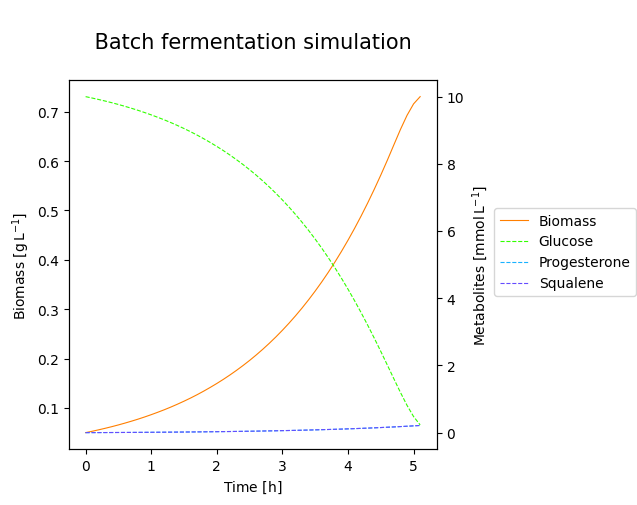

In [14]:
# plotting concentration in steady state
plot_concentrations(concentrations)
plt.title(" \n Batch fermentation simulation \n", size=15)
plt.savefig('figures/07_Bacth_fermentation_simul.png',bbox_inches='tight')

In [15]:
# printing concentrations in steady state
concentrations

,time,Biomass,Glucose,Progesterone,Squalene
0,0.0,0.050000,10.000000,0.000000,0.000000
1,0.1,0.052788,9.958406,0.000795,0.000801
2,0.2,0.055732,9.914475,0.001634,0.001647
3,0.3,0.058848,9.867997,0.002523,0.002542
4,0.4,0.062136,9.818954,0.003461,0.003487
5,0.5,0.065638,9.766742,0.004460,0.004494
6,0.6,0.069345,9.711470,0.005517,0.005560
7,0.7,0.073256,9.653182,0.006633,0.006684
8,0.8,0.077369,9.591877,0.007806,0.007867
9,0.9,0.081756,9.526516,0.009058,0.009128


In [29]:
#Squalene g/L
sql_gL = 0.213731/1000*410.73  #(mmol/L) / (mmol/mol) * (g/mol) = 0.08778573363000002
print(f"The final titre of squalene is {0.213731} mmol/L which is {0.088} g/L")

#Progesterone g/L
pro_gL = 0.212234/1000*314.46 #0.06673910363999999
print(f"The final titre of progesterone is {0.212234} mmol/L which is {0.067} g/L")

The final titre of squalene is 0.213731 mmol/L which is 0.088 g/L
The final titre of progesterone is 0.212234 mmol/L which is 0.067 g/L


As seen in the figure and table above, the batch fermentaiton ran for 5.1 hours before all of the glucose got consumed. The final progesterone titre reached 0.212 mmol/L (corresponding to 0.066 g/L) and the squalene titre reached 0.214 mmol/L (0.087 g/L)
The biomass reached 0.731 gDW/L.

In [32]:
0.087 *1000 # g/L * 1000 mg/g

87.0

In [31]:
#Checking if the flux of squalene is similar to that of progesterone.
flux_diff = model.optimize()['SQLS'] - model.optimize()['DM_progesterone_c'] #0.0003895894979365211 ~ 0.0004
print(f"The difference in flux between squalene and progesterone is {flux_diff} mmol/(gDW*h)")

The difference in flux between squalene and progesterone is 0.0003895894979365211 mmol/(gDW*h)


Text(0.5, 1.0, '\n Fluxes for batch fermentation simulation \n')

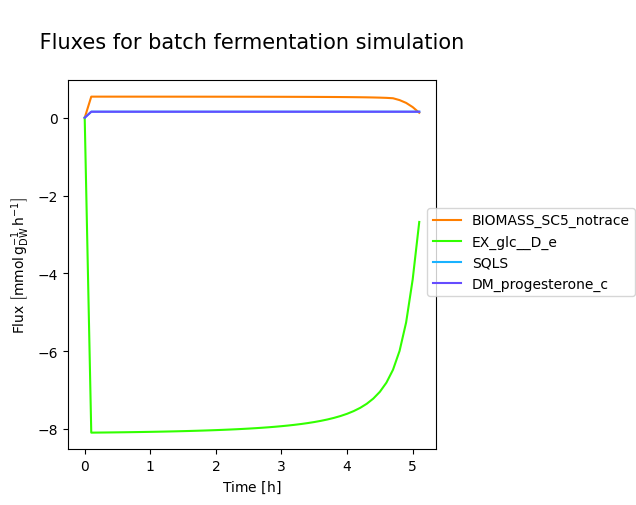

In [16]:
# Plotting fluxes at steady state
plot_trajectories(trajectories)
plt.title("\n Fluxes for batch fermentation simulation \n", size=15)

In [17]:
# printing fluxes at steady state
trajectories

,time,BIOMASS_SC5_notrace,EX_glc__D_e,SQLS,DM_progesterone_c
0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.1,0.542453,-8.093628,0.155867,0.154673
2,0.2,0.542412,-8.091914,0.155867,0.154673
3,0.3,0.542367,-8.090085,0.155867,0.154673
4,0.4,0.542319,-8.088137,0.155866,0.154673
5,0.5,0.542268,-8.086042,0.155866,0.154673
6,0.6,0.542213,-8.083801,0.155866,0.154673
7,0.7,0.542154,-8.081412,0.155866,0.154673
8,0.8,0.542092,-8.078869,0.155866,0.154673
9,0.9,0.542025,-8.076124,0.155866,0.154673


In this simulation, the fluxes changes rapidly in the beginning, representing the speed of which glucose is consumed while biomass and progesterone is produced. The negative value for glucose means that it is removed from the media when it is consumed by *S. cerevisiae*. In constrast, the positive values for biomass and progesterone means that it is produced. 

When glucose starts to become limited after 5 hours, the glucose flux increases, i.e. it is consumed at a lower rate. It doesn't seem to affect the growth until after approximately 4 hours. 

Progesterone is obviously produced at low levels with a constant flux of 0.1562, since we had to define this as constant due to the issues of running the simulation when the model had two objects. Therefore, the progesterone levels do not decrease as a consequence of the decreasing glucose and biomass levels. This would most certainly not be the case in real life, but is the best solution we have for the current tools we are using. One could also decide to set the progeterone production as the objective and then the biomass production to a constant optimal level, and the model would then show that progesterone production decrased as a consequence of decreasing glucose.

To make a better simulation in the future, it would be necessary to have two objectives for the simulation. It could then be interesting to test how the different concentrations of oxygen and glucose could affect growth and progesterone production. As we have found optimal levels for these substrates (see 04_phenotypic_phase_plane_analysis.ipynb), it is likely that a fed-batch simulation would give a higher progesterone titre, since this would allow keeping the glucose concentration more constant and closer to its optimal level during the simulation.


In the following code, we test how much we can increase the progesterone titre by adding more glucose initially.

In [18]:
# Make list manually
Prog = []
Glc = [4,36,60,100]

In [19]:
from matplotlib import pyplot as plt

In [20]:
with model:
    model.objective = {model.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
                    model.reactions.get_by_id('DM_progesterone_c'): baseline_max_growth} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = model.optimize()
    growth = solution.fluxes['BIOMASS_SC5_notrace']
    progesterone = solution.fluxes['DM_progesterone_c'] #*1000 /314.46
    o_uptake = solution.fluxes['EX_o2_e']
    glc_uptake = solution.fluxes['EX_glc__D_e']
    print(f"Growth rate in complete model: {growth} gDW/h")
    print(f"Progesterone productivity in complete model: {progesterone} mmol/gDW*h")
    print(f"Growth rate in complete model: {growth} gDW/h")
    print(f"Progesterone productivity in complete model: {progesterone} mmol/gDW*h")

Growth rate in complete model: 0.17708613542569557 gDW/h
Progesterone productivity in complete model: 0.15467338469999656 mmol/gDW*h
Growth rate in complete model: 0.17708613542569557 gDW/h
Progesterone productivity in complete model: 0.15467338469999656 mmol/gDW*h


In [21]:
dfba_result = {}

Vgmax = 8.5
Kg = 0.5
Vomax = 8.0
Oxy = 2
vmax_o2 = 15 
Ko = 0.024 
for glucose in Glc:
    with model:
        model.reactions.DM_progesterone_c.lower_bound = progesterone
        model.solver = "glpk"
        dfba_model = DfbaModel(model)
        X = KineticVariable("Biomass")
        Gluc = KineticVariable("Glucose")
        Pro = KineticVariable("Progesterone")
        # add kinetic variables to dfba_model
        dfba_model.add_kinetic_variables([X, Gluc, Pro])

        mu = ExchangeFlux("BIOMASS_SC5_notrace")
        v_G = ExchangeFlux("EX_glc__D_e")
        v_O = ExchangeFlux("EX_o2_e")
        v_P = ExchangeFlux("DM_progesterone_c")
        # add exchange fluxes to dfba_model
        dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_P])

        dfba_model.add_rhs_expression("Biomass", mu * X )
        dfba_model.add_rhs_expression("Glucose", v_G * X )
        dfba_model.add_rhs_expression("Progesterone", v_P * X )
        dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

        dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)
        dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)
        dfba_model.add_initial_conditions(
            {
                "Biomass": 0.05,
                "Glucose": glucose,
                "Progesterone": 0
            }
        )
        conc, traj = dfba_model.simulate(0.0, 100, 0.1, ["BIOMASS_SC5_notrace", "EX_glc__D_e", "DM_progesterone_c"])
        Prog.append(list(conc.Progesterone)[-1])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 23
Number of residual evaluations     = 70
Number of Jacobian evaluations     = 14
Number of nonlinear iterations     = 33
Number of error test failures      = 2
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 60


Final Run Statistics: 

Number of steps                    = 3
Number of residual evaluations     = 8
Number of Jacobian evaluations     = 1
Number of nonlinear iterations     = 4
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 10


Final Run Statistics: 

Number of steps                    = 9
Number of residual evaluations     = 20
Number of Jacobian evaluations     = 7
Number of nonlinear iterations     = 10
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 19


Final Run Statistics: 

Number of steps                    = 1
Number of residual evaluation

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 35
Number of residual evaluations     = 142
Number of Jacobian evaluations     = 18
Number of nonlinear iterations     = 69
Number of error test failures      = 10
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 118


Final Run Statistics: 

Number of steps                    = 7
Number of residual evaluations     = 20
Number of Jacobian evaluations     = 5
Number of nonlinear iterations     = 10
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 17


Final Run Statistics: 

Number of steps                    = 1
Number of residual evaluations     = 4
Number of Jacobian evaluations     = 1
Number of nonlinear iterations     = 2
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 12


Final Run Statistics: 

Number of steps                    = 17
Number of residual evalua

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 38
Number of residual evaluations     = 158
Number of Jacobian evaluations     = 19
Number of nonlinear iterations     = 77
Number of error test failures      = 11
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 125


Final Run Statistics: 

Number of steps                    = 7
Number of residual evaluations     = 24
Number of Jacobian evaluations     = 7
Number of nonlinear iterations     = 12
Number of error test failures      = 1
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 19


Final Run Statistics: 

Number of steps                    = 1
Number of residual evaluations     = 8
Number of Jacobian evaluations     = 2
Number of nonlinear iterations     = 4
Number of error test failures      = 1
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 9


Final Run Statistics: 

Number of steps                    = 17
Number of residual evaluat

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 40
Number of residual evaluations     = 168
Number of Jacobian evaluations     = 19
Number of nonlinear iterations     = 82
Number of error test failures      = 11
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 141


Final Run Statistics: 

Number of steps                    = 7
Number of residual evaluations     = 24
Number of Jacobian evaluations     = 6
Number of nonlinear iterations     = 12
Number of error test failures      = 1
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 18


Final Run Statistics: 

Number of steps                    = 1
Number of residual evaluations     = 8
Number of Jacobian evaluations     = 2
Number of nonlinear iterations     = 4
Number of error test failures      = 1
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 11


Final Run Statistics: 

Number of steps                    = 15
Number of residual evalua

In [22]:
# Glc = [10,20,40,80]
# Prog = [0.21,0.407906,0.761817,1.480404] 


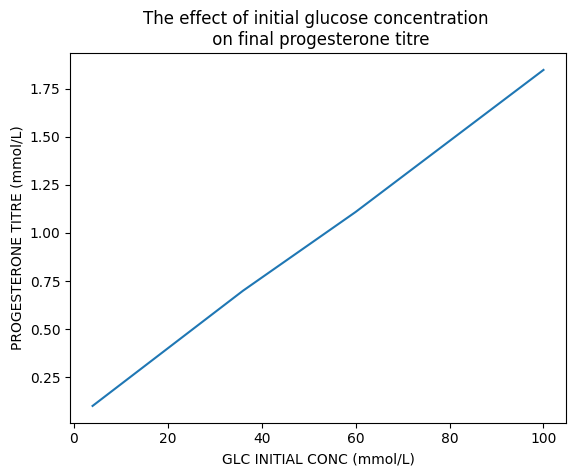

In [23]:
plt.plot(Glc,Prog)
# plt.legend(])
plt.xlabel("GLC INITIAL CONC (mmol/L)")
plt.ylabel("PROGESTERONE TITRE (mmol/L)")
plt.title("The effect of initial glucose concentration \n on final progesterone titre")
# plt.savefig('figures/05_phase_plane.png',bbox_inches='tight')
plt.savefig('figures/07_linear_relation.png',bbox_inches='tight')
plt.show()

As seen on the figure above, in our model there is a linear relation between added glucose initially and the final titre of progesterone that has been produced. 